In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from itertools import combinations
import seaborn as sns
import visualization
from Bio.Seq import Seq

In [4]:
def compute_rc_matrix(pwm):
    pwm_rc = np.zeros(pwm.shape)
    
    # swap + reverse A position (0) and T position (3)
    pwm_rc[:,0] = pwm[::-1,3]
    pwm_rc[:,3] = pwm[::-1,0]
    
    # swap + reverse C position (1) and G position (2)
    pwm_rc[:,1] = pwm[::-1,2]
    pwm_rc[:,2] = pwm[::-1,1]
    
    return pwm_rc

def ddG(Kd, ref_Kd, R=1.9872036e-3, T=295):
    '''
    compute ∆∆G in kcal/mol relative to reference Kd
    '''
    return R*T*np.log(Kd/ref_Kd)

def plot_paralog_comparison(s1,s2,TF_info,repeat_Zscores):    
    gs_kw = dict(width_ratios=[3.5, 1], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                                   ['left', 'lower right']],
                              gridspec_kw=gs_kw, figsize=(14,3),
                              constrained_layout=True)

    cmap_df = repeat_Zscores[[s1,s2]]
    cmap_df = cmap_df.sort_values(s1, ascending=False)
    vmax = np.min([np.max(np.array(cmap_df)), 8])
    sns.heatmap(cmap_df.T, vmin=np.min(np.array(cmap_df)),vmax=vmax,
                cmap='PRGn', center=0, ax=axd['left'])
    cbar = axd['left'].collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Z score',size=18)
    axd['left'].set_xticks(np.arange(39)+0.5)
    axd['left'].set_xticklabels([x[:4] for x in cmap_df.index], fontsize=14)
    axd['left'].set_xlabel('')
    axd['left'].set_yticklabels([x.split()[0] for x in [s1,s2]], fontsize=16)


    id1 = list(TF_info[TF_info['col_name']==s1]['Motif_ID'])[0]
    s1_df = np.array(pd.read_csv('pwms/%s.txt' % id1, delimiter='\t', index_col=0))
    s1_df = np.array([x-np.min(x) for x in s1_df])
    visualization.plot_weights_given_ax(axd['upper right'], s1_df.T,
                                        height_padding_factor=0.2,
                                        length_padding=1.0,
                                        subticks_frequency=1.0,
                                        highlight={})
    axd['upper right'].set_axis_off()

    id2 = list(TF_info[TF_info['col_name']==s2]['Motif_ID'])[0]
    s2_df = np.array(pd.read_csv('pwms/%s.txt' % id2, delimiter='\t', index_col=0))
    s2_df = np.array([x-np.min(x) for x in s2_df])

    visualization.plot_weights_given_ax(axd['lower right'], s2_df.T,
                                        height_padding_factor=0.2,
                                        length_padding=1.0,
                                        subticks_frequency=1.0,
                                        highlight={})
    axd['lower right'].set_axis_off()
    
    return fig

def paralog_comparison(TF_info, repeat_Zscores, family, species, min_motif=8):
    repeat_similarity = {}
    motif_similarity = {}
    family_df = TF_info[TF_info['Family_Name_Condensed']==family]
    family_df = family_df[family_df['TF_Species']==species.replace(' ','_')]
    pairs = list(combinations(family_df['TF_Name'].unique(),r=2))

    # for each pair, compute motif and repeat similarity
    for pair in pairs:
        try:
            # repeat similarity
            repeat_similarity[pair] = cos_sim(np.array(repeat_Zscores['%s (%s)' % (pair[0],species)]).reshape(1,-1),
                                              np.array(repeat_Zscores['%s (%s)' % (pair[1],species)]).reshape(1,-1))[0][0]

            # motif similarity for each possible alignment
            pwm1 = np.array(pd.read_csv('pwms/%s.txt' % list(family_df[family_df['TF_Name']==pair[0]]['Motif_ID'])[0], delimiter='\t', index_col=0))
            pwm2 = np.array(pd.read_csv('pwms/%s.txt' % list(family_df[family_df['TF_Name']==pair[1]]['Motif_ID'])[0], delimiter='\t', index_col=0))
            motif_sim_list = []
            for i in range(pwm1.shape[0]-min_motif+1):
                for j in range(pwm2.shape[0]-min_motif+1):
                    rc = compute_rc_matrix(pwm1[i:i+min_motif])
                    motif_sim_list.append(cos_sim(pwm1[i:i+min_motif].reshape(1,-1), pwm2[j:j+min_motif].reshape(1,-1))[0][0])
                    motif_sim_list.append(cos_sim(rc.reshape(1,-1), pwm2[j:j+min_motif].reshape(1,-1))[0][0])

            motif_similarity[pair] = np.max(motif_sim_list)
        except:
            if pair in repeat_similarity:
                del repeat_similarity[pair]
            if pair in motif_similarity:
                del motif_similarity[pair]
        
    return motif_similarity, repeat_similarity

In [5]:
# import data -- all of the following are available on our OSF repository
TF_info = pd.read_csv('CISBP_PBM_info_families.csv', index_col=0)
repeat_Zscores = pd.read_csv('Zscores_repeatsonly_byTF.csv', index_col=0)
all_Zscores = pd.read_csv('Zscores_byTF.csv', index_col=0)

kBT = 0.593

# Identify same paralogs with similar motifs but different repeat preferences

# first plot all paralog comparisons for bHLH
this analysis can be repeated for any family

In [6]:
family = 'bHLH'

bHLH = TF_info[TF_info['Family_Name_Condensed']==family]
print(bHLH.value_counts('TF_Species'))

species_list = ['Mus musculus', 'Arabidopsis thaliana', 'Neurospora crassa', 'Cannabis sativa']

TF_Species
Mus_musculus                17
Arabidopsis_thaliana        10
Neurospora_crassa            8
Cannabis_sativa              7
Caenorhabditis_elegans       4
Saccharomyces_cerevisiae     3
Homo_sapiens                 2
Physcomitrella_patens        2
Oryza_sativa                 1
dtype: int64


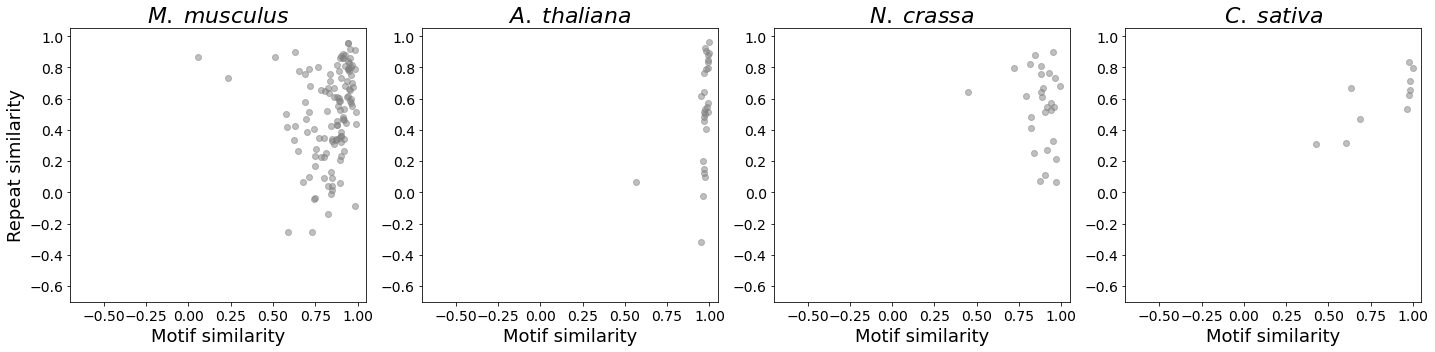

In [9]:
fig = plt.figure(figsize=(20,5))

for i, species in enumerate(species_list):
    ax = fig.add_subplot(1,4,i+1)

    m,r = paralog_comparison(TF_info, repeat_Zscores, family, species)
    ax.scatter(m.values(), r.values(), color='gray', alpha=0.5)
    
    ax.set_xlabel('Motif similarity', fontsize=18)
    if i==0:
        ax.set_ylabel('Repeat similarity', fontsize=18)


    speciesname2print = species.split(' ')[0][:1]+'.\;'+species.split(' ')[1]
    ax.set_title('$%s$' % speciesname2print, fontsize=22)
    ax.set_ylim(-0.7,1.05)
    ax.set_xlim(-0.7,1.05)
    ax.tick_params(labelsize=14)

fig.tight_layout()
# fig.savefig('bHLH_paralogs.png')

## now plot some pairwise paralog comparisons for mouse bHLH proteins

In [10]:
m, r = paralog_comparison(TF_info, repeat_Zscores, 'bHLH', 'Mus musculus')

# identify paralogs with very similar motifs but different repeat prefs
diff_repeats = []
for pair in m:
    if m[pair]>0.93 and r[pair]<0.5:
        diff_repeats.append(pair)
        
print(diff_repeats)

[('Twist2', 'Bhlhe22'), ('Tfeb', 'Bhlhe41'), ('Tfeb', 'Arntl')]


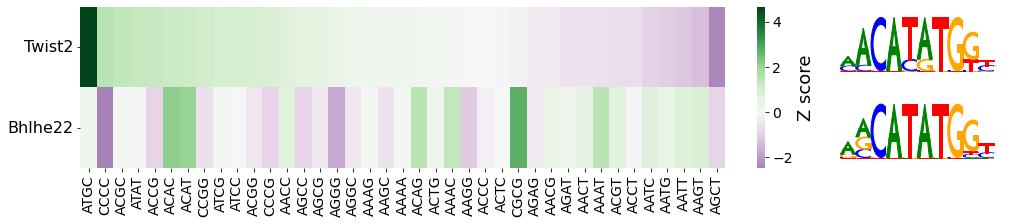

In [11]:
# plot some examples

s1 = 'Twist2 (Mus musculus)'
s2 = 'Bhlhe22 (Mus musculus)'
fig = plot_paralog_comparison(s1,s2,TF_info, repeat_Zscores)
# fig.savefig('paralog_plots/Mm_Twist2_Bhlhe22.png')

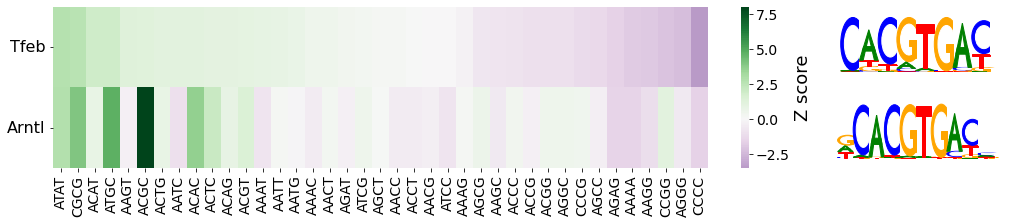

In [12]:
s1 = 'Tfeb (Mus musculus)'
s2 = 'Arntl (Mus musculus)'
fig = plot_paralog_comparison(s1,s2,TF_info, repeat_Zscores)
# fig.savefig('paralog_plots/Mm_Tfeb_Arntl.png')

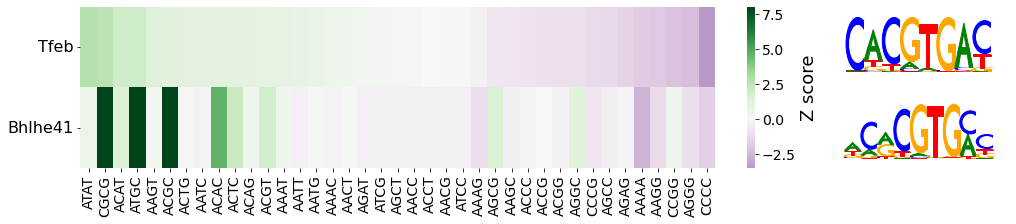

In [13]:
s1 = 'Tfeb (Mus musculus)'
s2 = 'Bhlhe41 (Mus musculus)'
fig = plot_paralog_comparison(s1,s2,TF_info, repeat_Zscores)
# fig.savefig('paralog_plots/Mm_Tfeb_Bhlhe41.png')